# Pre-Workout

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from keras.models import Sequential
from tensorflow.keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
import keras
import numpy as np
import PIL
from PIL import Image
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
from scipy.spatial import distance
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

In [ ]:
!unzip -q /content/drive/MyDrive/datasets/unbalanced_dataset_2304.zip # training data

In [ ]:
!unzip -q /content/drive/MyDrive/datasets/challenge_test_data.zip # challenge data

In [ ]:
!cp drive/MyDrive/utils.py . # copy utils.py to current directory

In [ ]:
def create_model(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding = 'same', input_shape=input_shape + (3,)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Conv2D(32, (3, 3), padding = 'same', strides = 2))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Conv2D(64, (3, 3), padding = 'same', strides = 2))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Conv2D(128, (3, 3), padding = 'same', strides = 2))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Conv2D(256, (3, 3), padding = 'same', strides = 2))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(GlobalAveragePooling2D())

    model.add(Dense(101)) # 101 number of classes
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer = tf.keras.optimizers.Adam(learning_rate=lr),
                  metrics=['accuracy'])

    return model

# Dataset for training 

In [ ]:
TRAINING_PATH = "/content/unbalanced_dataset_2304/training"
train_data_dir = TRAINING_PATH
target_shape = (256, 256)
# validation_data_dir = TRAINING_PATH

epochs = 100
batch_size = 16
lr = 0.001

nb_train_samples = 26434 # number of training images * 0.8
nb_validation_samples = 6570 # number of validation images * 0.2

In [ ]:


# data generator
train_datagen = ImageDataGenerator(
    rescale= 1./255,
    shear_range=0.2, #apply shear mapping
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # !!!

# training set generator
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=target_shape,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle = True,
    subset='training')

#validation set generator
validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=target_shape,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle = False,
    subset='validation')

#  CNN model

## create

In [ ]:

model = create_model(target_shape)

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5) # stop the training if loss has not improved for 5 epochs
checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/saved_models/CNN_Keras_1/checkpoints/victor_CNN_droput_Adam_default_lowdataaugm.hdf5', verbose=1, save_best_only=True)


## Training

In [ ]:
model.summary()

In [ ]:
 model.fit(
     train_generator,
     steps_per_epoch=nb_train_samples // batch_size,
     epochs=epochs,
     callbacks=[early_stop, checkpointer],
     validation_data=validation_generator,
     validation_steps=nb_validation_samples // batch_size
     )

## save model

In [ ]:
#model.save_weights('/content/drive/MyDrive/saved_weights/CNN_Keras_1/unbalanced_victor_adam_default_nodropout_ligthdataaug.h5') ## change
MODEL_SAVE_PATH = '/content/drive/MyDrive/saved_models/CNN_Keras_1/unbalanced_victor_adam_default_nodropout_ligthdataaug.h5'
model.save(MODEL_SAVE_PATH)


## Load saved model

In [ ]:
MODEL_SAVE_PATH = '/content/drive/MyDrive/models/Sandro_CNN_low_data_aug_Victor.h5'
model = keras.models.load_model(MODEL_SAVE_PATH)

## Create feature extractor

In [ ]:
feat_extractor = Model(inputs= model.input, outputs=model.get_layer('global_average_pooling2d_6').output) # we get the 256




# Evaluation

## methods

## dataset

In [ ]:
GALLERY_PATH = "/content/gallery/"
QUERY_PATH = "/content/query/"

In [ ]:
target_shape = (256, 256)

utils.clean_dataset(GALLERY_PATH)
utils.clean_dataset(QUERY_PATH)

gallery = utils.Dataset(data_path=GALLERY_PATH).get_dataset()
query = utils.Dataset(data_path=QUERY_PATH).get_dataset()


None /content/gallery/367305c879da423477c25714abaa99812ceee04b.jpg
webp /content/gallery/f96abd33dd972083e261bbe708592977a09775ef.jpg
webp /content/query/c09be2fdaa6b56e91e07dcbd2ac52c7216cfdc2e.jpg
webp /content/query/245711a4ebf210d031fc6321e990d1bc6ef8efa8.jpg
None /content/query/dcf8b2e841ada444663339044d7778b7a1466611.jpg
Loaded 6355 images from /content/gallery/ 
Loaded 65 images from /content/query/ 


In [ ]:
import utils
gallery_features, gallery_urls, gallery_labels = utils.compute_features(gallery, feat_extractor)
query_features, query_urls, query_labels = utils.compute_features(query, feat_extractor)

results_eu = utils.compute_results(query_features, gallery_features, query_urls, gallery_urls)
results_cos = utils.compute_results(query_features, gallery_features, query_urls, gallery_urls, dist= 'cosine')
#evaluate(results)

{1: 49, 3: 72, 5: 89, 10: 125, 11: 259} no train 

# competition

In [ ]:
import requests
import json

def submit(results, url="http://tinyurl.com/IML2022"):
    res = json.dumps(results)
    response = requests.post(url, res)
    try:
        result = json.loads(response.text)
        print(f"accuracy is {result['results']}")
    except json.JSONDecodeError:
        print(f"ERROR: {response.text}")


In [ ]:
mydata = dict()
mydata['groupname'] = "The Ostriches"

mydata["images"] = results_eu
submit(mydata)

mydata["images"] = results_cos
submit(mydata)



## display errors

In [ ]:
ev, err =  utils.evaluate(results_eu, query_labels, gallery_labels)
it = iter(err)

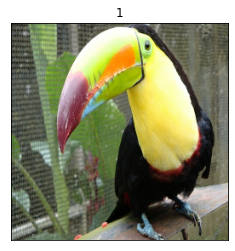

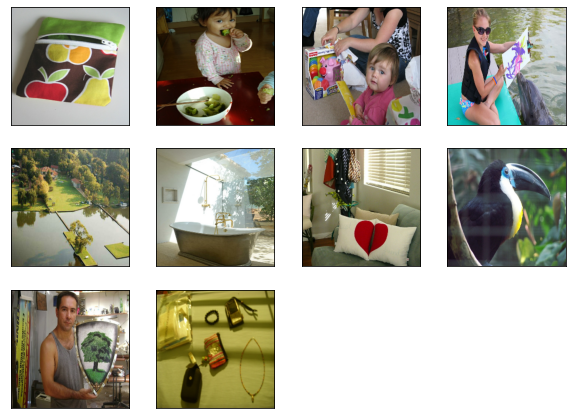

In [ ]:
query_item = next(it)
utils.display_results(query_item, results, query_labels, gallery_labels, target_shape)